## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [1]:
# The following will initialize SPARK
#
import findspark
findspark.init("C:/spark/spark-2.2.0/")
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
from IPython.display import clear_output, Image, display
# Below will read all the parquet files that were supplied in BlackBoard for the full set of files that 
# comprise the Enron email data set. It uses the wildcard '*' to get all the parquet files loaded into our dataframe (df)
# The last 2 commands display our datframe and the total email count in our dataframe
#
file_location = "C:/Users/aadit/Downloads/Partial_Enron_Cleaned/part-r-*.parquet"
file_type = "parquet"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)


display(df)
df.count()

DataFrame[mid: bigint, sender: string, timestamp: string, omid: string, subject: string, body: string, folder: string, body_cleaned: array<string>, concepts: array<string>]

13861

In [4]:
# Create a view or table
# Change the subject text to lower case and the timestamp to a date whereby we drop the hours and minutes such
# that the format of the timestamp data is now 'YYYY-MM-DD'
# 
from pyspark.sql.functions import lower, col, date_format
# 
df = df.select("mid","sender", date_format(col("timestamp"),'yyyy-MM-dd').alias("timestamp"), \
               "omid",lower(col('subject')).alias('subject'), "body", "folder","body_cleaned", "concepts")
#
temp_table_name = 'df'
df.createOrReplaceTempView('df')
#display(df)
#df.count()


In [5]:
# The dataframe has already been set to the full corpus. We only execute below code to filter the dataframe
# such that we include emails for 2001 (October and November) as these 2 months are of interest due to
# announcements at Enron whereby the compay stock was plunging and investigations started
#
df_octnov=spark.sql("select * from df where to_date(timestamp,'yyyy-MM') between '2001-10' and '2001-12'")
df_octnov.rdd.count()

2859

In [6]:
# The following will import all the gensim and nltk libraries that we used to lemmatize as remove stopwords from the corpus
#
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

C:\Users\aadit\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Below were several useful functions that allowed the team to pre-process data. 
# some of these functions were used initially and then abandoned as we came up with better methods
# to pre-process as the prject progressed.  I included these to show the evolution of the code set 
# even if we eventually did not use some of these functions
#           
import re, html, string
rem = ['(?s)<TYPE>GRAPHIC.*?</TEXT>',
'(?s)<TYPE>EXCEL.*?</TEXT> ',
'(?s)<TYPE>PDF.*?</TEXT>',
'(?s)<TYPE>ZIP.*?</TEXT>',
'(?s)<TYPE>COVER.*?</TEXT>',
'(?s)<TYPE>CORRESP.*?</TEXT>',
'(?s)<TYPE>EX-10[01].INS.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].INS.*?</TEXT>',
'(?s)<TYPE>EX-10[01].SCH.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].SCH.*?</TEXT>',
'(?s)<TYPE>EX-10[01].CAL.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].CAL.*?</TEXT>',
'(?s)<TYPE>EX-10[01].DEF.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].LAB.*?</TEXT>',
'(?s)<TYPE>EX-10[01].LAB.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].LAB.*?</TEXT>',
'(?s)<TYPE>EX-10[01].PRE.*?</TEXT>',
'(?s)<TYPE>EX-99.SDR [KL].PRE.*?</TEXT>',
'(?s)<TYPE>EX-10[01].REF.*?</TEXT>',
'(?s)<TYPE>XML.*?</TEXT>',
'<TYPE>.*',
'<SEQUENCE>.*',
'<FILENAME>.*',
'<DESCRIPTION>.*',
'(?s)(?i)<Head>.*?</Head>',
'(?s)(?i)<Table.*?</Table>',
'(?s)<[^>]*>']
#
# Function clean: 
# Purpose: Remove the garbage text from a record and replace occurrence of a period with a period and then a space
# Arguments: txt = an email record to be used in lambda map commands
#           
def clean(txt):
#  txt=txt.replace (".",". ")
  doc = re.sub("\xa0|\n|\t|—|_"," ",html.unescape(txt))
  remove = string.punctuation
  remove = remove.replace(".", "") # don't remove periods
  pattern = r"[{}]".format(remove) # create the pattern
#  bdm_doc=re.sub(pattern, "", txt) 
#  return re.sub("(?s) +"," ",re.sub(rem[-1]," ",bdm_doc))
  return re.sub("(?s) +"," ",re.sub(rem[-1]," ",doc))
#
# Function add_space:
# Purpose: replaces occurrence of period to a period followed by a space
# Argument: s = an email record as a string
#
def add_space(s):
    res = re.sub('\s+$', '', re.sub('\s+', ' ', re.sub('\.', '. ', s)))
    if res[-1] != '.':
       res += '.'
    return res
#
# Function remove_punct:
# Purpose: removes all punctuation and numbers from an email record 
# Argument: s = an email record as a string
#
def remove_punct(s):
  remove=string.punctuation
  remove=remove+'\0123456789[]'
  s.translate(None, remove)
#
# Function remove_common_words:
# Purpose: removes any common words that are intialized as a list inside the function
# Argument: my_list_of_lists = defined as a lists od lists of all the email records in the corpus
#
def remove_common_words(my_list_of_lists):
  my_common_words = ['messag','clean','bodi','send','forward', 'attach','subject','font','enron','origin','mail','pmto','file']
  new_list_outer=[]
  new_list_inner=[]
  for a_list in my_list_of_lists:
    new_list_inner=[]
    for a_word in a_list:
      if a_word not in my_common_words and a_word is not None:
        new_list_inner.append(a_word)
    new_list_outer.append(new_list_inner)
  return new_list_outer

In [8]:
#
# Function lemmatize_stemming:
# Purpose: Uses nltk to lemmatize the data
# Argument: text = an email record 
#
def lemmatize_stemming(text):
  lmtzr = WordNetLemmatizer()
  return lmtzr.lemmatize(text)
#
# Function lemstep_preprocess:
# Purpose: function name is a misnomer the stem code was removed as it was deemed to severe in changing the data
#          function will call the lemmatize function as well as use gensim to remove STOPWORDS
#          decision was made to keep words (tokens) that had a length >3
# Argument: s = an email record 
#
def lemstem_preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
      result.append(lemmatize_stemming(token))
  return result

In [9]:
#
# Below code block was key for pre-processing and tokenizing the data
# t is assigned as a filter on our dataframe to extract the email body values 
# tokens is assigned after a map to 
# 1) strip spaces and lower case the email body
# 2) split an email on spaces into words in the email
# 3) only include the words if they are alpha
# 4) only include words that have a length > 2
# 5) send the words to the pre-process function to lemmatize and remove stop words
#
t = df.rdd.map(lambda x: x['body']).filter(lambda x: x is not None)
tokens= t   \
   .map(lambda email:email.strip().lower())  \
   .map(lambda email: re.split(" ", email))  \
   .map(lambda word: [x for x in word if x.isalpha()]) \
   .map(lambda word: [x for x in word if len(x) >2])   \
   .map(lambda email: lemstem_preprocess(str(email))).collect()

In [10]:
#
# Same as above block but need to have separate dataframe store to show all visaulizations at the end for full corpus and octnov corpus
# Below code block was key for pre-processing and tokenizing the data
# t is assigned as a filter on our dataframe to extract the email body values 
# tokens is assigned after a map to 
# 1) strip spaces and lower case the email body
# 2) split an email on spaces into words in the email
# 3) only include the words if they are alpha
# 4) only include words that have a length > 2
# 5) send the words to the pre-process function to lemmatize and remove stop words
#
t_octnov = df_octnov.rdd.map(lambda x: x['body']).filter(lambda x: x is not None)
tokens_octnov= t_octnov   \
   .map(lambda email:email.strip().lower())  \
   .map(lambda email: re.split(" ", email))  \
   .map(lambda word: [x for x in word if x.isalpha()]) \
   .map(lambda word: [x for x in word if len(x) >2])   \
   .map(lambda email: lemstem_preprocess(str(email))).collect()

In [11]:
# Simple priont of the tokens 
#
#print(tokens)
print(tokens_octnov)

[['girl', 'carrie', 'shapiro', 'october', 'committee', 'speakeryour', 'thanks', 'kevin', 'october', 'carrie', 'shapiro', 'committee', 'vice', 'pres', 'pipeline', 'integrity', 'hasagreed', 'speak', 'session', 'pipeline', 'infrastructure', 'contacted', 'michel', 'nelsonenron', 'transportation', 'servicespo', 'send', 'conf', 'invite', 'earliest', 'property', 'enron', 'relevant', 'affiliate', 'andmay', 'contain', 'confidential', 'privileged', 'material', 'sole', 'theintended', 'recipient', 'distribution', 'disclosure', 'byothers', 'strictly', 'intended', 'recipient', 'receive', 'contact', 'sender', 'replyto', 'enron', 'delete', 'allcopies', 'attachment', 'notintended', 'offer', 'create', 'evidence', 'abinding', 'enforceable', 'contract', 'enron', 'intended', 'recipient', 'berelied', 'basis', 'contract', 'estoppel'], ['rescheduled', 'wednesday', 'thedial', 'information', 'fred', 'october', 'tracy', 'fred', 'hoang', 'demetrics', 'adaytum', 'project', 'hear', 'hoping', 'join', 'following', 'i

In [12]:
# Invoke the gensim library to create a corpus dictionary  -- full corpus
#
my_dictionary = gensim.corpora.Dictionary(tokens)

In [13]:
# Invoke the gensim library to create a corpus dictionary  -- octnov corpus
my_dictionary_octnov=gensim.corpora.Dictionary(tokens_octnov)

In [14]:
# A simple loop to ensure that our dictionary was created successfully. Prints 10 dictionary items
#
count = 0
for k, v in my_dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 attached
1 devil
2 existing
3 include
4 juan
5 lateral
6 latest
7 loop
8 mainline
9 maop
10 option


In [15]:
# A simple loop to ensure that our dictionary was created successfully. Prints 10 dictionary items for octnov
#
count = 0
for k, v in my_dictionary_octnov.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abinding
1 affiliate
2 allcopies
3 andmay
4 attachment
5 basis
6 berelied
7 byothers
8 carrie
9 committee
10 conf


In [16]:
# Below shows code that we commented out as we made a decision to to filter out extremes
# as we processed the data well enough to be able to use bag of words as we had no stop words 
# and were left with only meaningful words
#my_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
#my_dictionary.filter_extremes(no_below=15, no_above=0.3)

In [17]:
# Intialize GENSIM Bag of Words (BOW) full corpus
#
bow_corpus = [my_dictionary.doc2bow(doc) for doc in tokens]
#print(bow_corpus)

In [18]:
# # Intialize GENSIM Bag of Words (BOW) octnov
#
bow_corpus_octnov =  [my_dictionary_octnov.doc2bow(doc) for doc in tokens]

In [19]:
# Simple display to see the 100th element for BOW, the first tuple element is the word ID and the second is the wordCOUNT
#
bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                               my_dictionary[bow_doc_100[i][0]], 
bow_doc_100[i][1]))

Word 0 ("attached") appears 1 time.
Word 19 ("account") appears 2 time.
Word 40 ("credit") appears 2 time.
Word 50 ("file") appears 1 time.
Word 91 ("recently") appears 1 time.
Word 94 ("requesting") appears 1 time.
Word 110 ("union") appears 2 time.
Word 119 ("forward") appears 1 time.
Word 154 ("enron") appears 1 time.
Word 168 ("october") appears 3 time.
Word 362 ("like") appears 1 time.
Word 403 ("needed") appears 1 time.
Word 445 ("previously") appears 1 time.
Word 476 ("restricted") appears 1 time.
Word 522 ("trade") appears 1 time.
Word 586 ("attention") appears 1 time.
Word 592 ("best") appears 1 time.
Word 759 ("transaction") appears 1 time.
Word 785 ("september") appears 1 time.
Word 837 ("opened") appears 1 time.
Word 863 ("split") appears 1 time.
Word 889 ("bond") appears 2 time.
Word 947 ("kind") appears 1 time.
Word 1042 ("mail") appears 1 time.
Word 1078 ("reply") appears 1 time.
Word 1098 ("service") appears 3 time.
Word 1126 ("come") appears 1 time.
Word 1169 ("group")

In [20]:
# Initialize GENSIM TFIDF algoritm and a simple display to show the word weighted values (fullcorpus)
#
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.081271690422935861),
 (1, 0.28412580079607358),
 (2, 0.14555265277193563),
 (3, 0.11838664292460559),
 (4, 0.20572407897239706),
 (5, 0.23986214602761213),
 (6, 0.14448951681988634),
 (7, 0.21364963801057768),
 (8, 0.2635443733985392),
 (9, 0.33998031438654847),
 (10, 0.26240717425441684),
 (11, 0.20034403041036125),
 (12, 0.13609084473225058),
 (13, 0.17077203443730593),
 (14, 0.24099716516533759),
 (15, 0.22352574805438807),
 (16, 0.43462987558882099),
 (17, 0.21861474454378835),
 (18, 0.15692862833854657)]


In [21]:
# Initialize GENSIM TFIDF algoritm and a simple display to show the word weighted values   (octnov)
#
from gensim import corpora, models
tfidf_octnov = models.TfidfModel(bow_corpus_octnov)
corpus_tfidf_octnov = tfidf_octnov[bow_corpus_octnov]

In [22]:
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#
# The below function will build the LDA model for BOW and TFIDF
# Will create a list such that the cohesion scores and LDA models are stored in separate lists by topic
# We have chosen to start at 4 topics and continue calculating LDA in increments of 2 topics up to 16
# We calculate for 4,6,8,10,12,14,16 number of topics 
#
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics, id2word=dictionary, passes=100, workers=8)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Call function to build the lda model and to get cohesion values for number of topics
# This is for the FULL BOW dataset 
# Plot Coherence score against a number of topics
# 
#model_list, coherence_values = compute_coherence_values(dictionary=my_dictionary, corpus=bow_corpus, texts=tokens, start=4, limit=18, step=2)
#model_list, coherence_values = compute_coherence_values(dictionary=my_dictionary, corpus=corpus_tfidf, texts=tokens, start=4, limit=18, step=2)
model_list_full, coherence_values_full = compute_coherence_values(dictionary=my_dictionary, corpus=bow_corpus, texts=tokens, start=4, limit=18, step=2)

In [24]:
# Display the top topics for the models --randomly picked num topics=4 , first in list for full data set
for idx, topic in model_list_full[0].print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.013*"power" + 0.009*"energy" + 0.008*"market" + 0.008*"price" + 0.006*"state" + 0.005*"california" + 0.004*"said" + 0.004*"customer" + 0.003*"rate" + 0.003*"ferc"
Topic: 1 Word: 0.007*"know" + 0.006*"like" + 0.006*"time" + 0.005*"need" + 0.004*"meeting" + 0.004*"enron" + 0.004*"free" + 0.004*"week" + 0.004*"work" + 0.004*"want"
Topic: 2 Word: 0.034*"enron" + 0.018*"company" + 0.009*"said" + 0.007*"million" + 0.007*"stock" + 0.007*"energy" + 0.006*"business" + 0.005*"share" + 0.005*"financial" + 0.004*"market"
Topic: 3 Word: 0.010*"enron" + 0.008*"attached" + 0.008*"forwarded" + 0.008*"know" + 0.008*"need" + 0.008*"agreement" + 0.007*"contract" + 0.007*"deal" + 0.006*"intended" + 0.006*"copy"


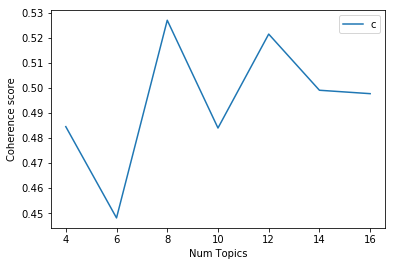

In [25]:
# Plot Coherence score against a number of topics. This plot is for the FULL data set
# Show graph
#
import matplotlib.pyplot as plt
limit=18; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values_full)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Import the LDAVis library
import pyLDAvis.gensim

In [27]:
# Since cohesion showed high scores for both 10 and 12 for FULL Dataset, Display both 10 and 12 topics
# Dsiplay cohesion full fdataset for 12 topics
lda_vis_full = pyLDAvis.gensim.prepare(model_list_full[4],bow_corpus,my_dictionary,sort_topics=False)
pyLDAvis.display(lda_vis_full)

In [28]:
# Dsiplay cohesion full fdataset for 10 topics
#
lda_vis_full = pyLDAvis.gensim.prepare(model_list_full[3],bow_corpus,my_dictionary,sort_topics=False)
pyLDAvis.display(lda_vis_full)

In [36]:
# Since the cohesion scores tend to show a drop at 14 topics,  display 14 topics to see how the clusters look
#
lda_vis_full = pyLDAvis.gensim.prepare(model_list_full[2],bow_corpus,my_dictionary,sort_topics=False)
pyLDAvis.display(lda_vis_full)

In [30]:
#This line is a split between the full corpus calculations abobe and the smaller data set of octnov done below
#
#
#
#

In [31]:
# Call function to build the lda model and to get cohesion values for number of topics
# This is for the octnov dataset 
# Plot Coherence score against a number of topics
# 
#model_list, coherence_values = compute_coherence_values(dictionary=my_dictionary, corpus=bow_corpus, texts=tokens, start=4, limit=18, step=2)
#model_list, coherence_values = compute_coherence_values(dictionary=my_dictionary, corpus=corpus_tfidf, texts=tokens, start=4, limit=18, step=2)
model_list, coherence_values = compute_coherence_values(dictionary=my_dictionary_octnov, corpus=bow_corpus_octnov, texts=tokens_octnov, start=4, limit=18, step=2)




In [32]:
# Display the top topics for the models --randomly picked first in list where num topics=4 for small octnov
for idx, topic in model_list[0].print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.012*"know" + 0.010*"need" + 0.009*"forwarded" + 0.008*"like" + 0.007*"meeting" + 0.006*"enron" + 0.006*"mark" + 0.005*"john" + 0.005*"work" + 0.005*"time"
Topic: 1 Word: 0.020*"power" + 0.014*"energy" + 0.010*"state" + 0.010*"market" + 0.009*"price" + 0.008*"said" + 0.007*"california" + 0.005*"ferc" + 0.005*"utility" + 0.005*"cost"
Topic: 2 Word: 0.027*"enron" + 0.013*"company" + 0.006*"said" + 0.005*"business" + 0.005*"stock" + 0.005*"million" + 0.005*"year" + 0.004*"time" + 0.004*"energy" + 0.004*"share"
Topic: 3 Word: 0.010*"enron" + 0.009*"contract" + 0.009*"agreement" + 0.007*"intended" + 0.007*"information" + 0.006*"credit" + 0.005*"change" + 0.005*"need" + 0.005*"deal" + 0.005*"message"


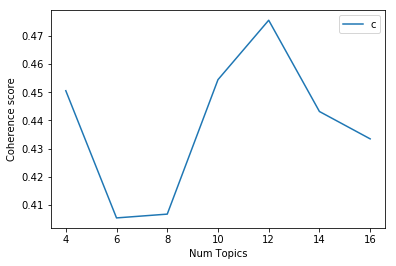

In [33]:
# Plot Coherence score against a number of topics. This plot is for the octnov data set
# Show graph
#
import matplotlib.pyplot as plt
limit=18; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Since cohesion showed highest score for 8 topics for octnov,  
# LDA VIS 8 topics which is the 3rd element in the list (element 2 as sunscript starts at 0)
#
lda_vis_octnov12 = pyLDAvis.gensim.prepare(model_list[2],bow_corpus_octnov,my_dictionary_octnov,sort_topics=False)
pyLDAvis.display(lda_vis_octnov12)

In [35]:
# Since cohesion showed a cohesion drop from best cohesion at 8 to a lower cohesion at 12
# Display LDA Vis for 12 topics
#
lda_vis_octnov12 = pyLDAvis.gensim.prepare(model_list[4],bow_corpus_octnov,my_dictionary_octnov,sort_topics=False)
pyLDAvis.display(lda_vis_octnov12)